<div style="background-color:#035FCA; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 1px solid #19180F; border-radius:10px"> ProphetNet </div>

<div style="background-color:#BFD4F3; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">🔧 Architecture Overview⚙️</div>
 </div>
<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
The architecture consists of two main components: the encoder and the decoder.<br>
    1. <b>Encoder</b>: The encoder analyses an input sequence, often a source language sequence, to collect contextual information. The "enc_input" sequence in the figure represents the input sequence, which might be tokenized text or any other sequential data. The encoder then encodes the data, as indicated by the arrow pointing from "enc_input" to "enc_output." To capture hierarchical and contextual information, the input sequence is processed through various layers of neural network units, such as transformers or recurrent neural networks (RNNs). The "enc_output" variable represents the encoder's final output, which contains the encoded representation of the input sequence.<br><br>
2. <b>Decoder</b>: The decoder takes the encoded representation from the encoder and creates an output sequence, which is often the target language sequence or a model-generated sequence. The "dec_input" in the figure indicates the decoder's input, which is normally a specific token signifying the start of the sequence. The decoder subsequently decodes the data, as indicated by the arrow pointing from "dec_input" to "dec_output." Similar to the encoder, this stage includes processing the input sequence via numerous layers of neural network units with the goal of creating the target sequence. The "dec_output" variable represents the decoder's final output, which contains the created or translated sequence.<br><br>
Additionally, there are some additional components and connections in the architecture:<br>
- <b>Input Data and Output Data</b>: These nodes reflect the ProphetNet model's input and output data. The "input_data" node represents the sequence or data supplied into the encoder, while the "output_data" node represents the decoder's created or translated sequence.<br>
- <b>Future N-gram prediction</b>: This component, represented by the "future_ngram" node, represents the model's capacity to anticipate future tokens based on context. It takes the encoded representation from the encoder and predicts tokens, which are subsequently supplied into the decoder during the decoding process.<br>
<br>
Overall, the ProphetNet architecture uses the encoding and decoding phases, as well as future token prediction, to construct high-quality and contextually coherent sequences for different sequence-to-sequence activities such as language production and translation.</div>



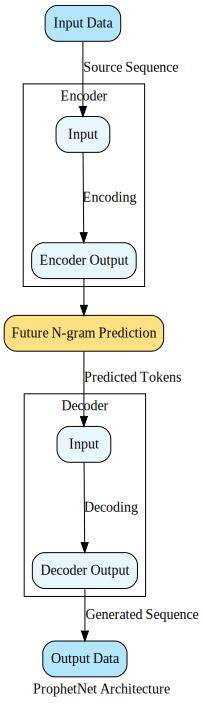

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/prophetnet.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Importing modules
    </div>

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, ProphetNetModel, AdamW
from tqdm import tqdm

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Defining the dataset class with train and test modes along with train function and instantiating the model and tokenizer
    </div>

In [ ]:
class DisasterTweetDataset(Dataset):
    def __init__(self, data_path, tokenizer,mode="Train"):
        self.data = pd.read_csv(data_path)
        self.tokenizer = tokenizer
        self.mode = mode
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        tweet = self.data.loc[index, 'text']
        if self.mode == "Train":
            target = self.data.loc[index, 'target']
            encoding = self.tokenizer(tweet, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()
            return {'input_ids': input_ids, 'attention_mask': attention_mask, 'target': target}
        elif self.mode=="Test":
            encoding = self.tokenizer(tweet, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()
            return {'input_ids': input_ids, 'attention_mask': attention_mask}
            
# Define the training function
def train(model, train_dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for step,batch in tqdm(enumerate(train_dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=torch.zeros_like(input_ids))
        logits = outputs.last_hidden_state[:, 0, :]  # Use the first token's representation
        predictions = torch.argmax(logits, dim=1)
        
        loss = criterion(logits, targets)
        total_loss += loss.item()
        if step%100==0:
            print("Step-{},Loss-{}".format(step,loss.item()))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return total_loss

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/prophetnet-large-uncased")
model = ProphetNetModel.from_pretrained("microsoft/prophetnet-large-uncased")



<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Setting device
    </div>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Loading the dataset
    </div>

In [ ]:
train_dataset = DisasterTweetDataset("/kaggle/input/nlp-getting-started/train.csv", tokenizer,mode="Train")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Checking the length of trainloader to figure out the number of steps per epoch with current batch size.
    </div>

In [ ]:
print(len(train_dataloader))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Sanity check of the dataloader
    </div>

In [ ]:
for batch in train_dataloader:
    print(batch)
    break

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Initialising the optimizer and loss function along with training the model for 5 epochs
    </div>

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
model.to(device)
for epoch in range(10):
    loss = train(model, train_dataloader, optimizer, device)
    print(f"Epoch: {epoch+1}, Loss: {loss}")

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Train more for better results ! The loss is decreasing across epochs but shall take time !
    </div>

In [ ]:
# Save the trained model
model.save_pretrained("ProphetNet")

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Loading the test dataset and creating the dataloader
    </div>

In [ ]:
# Load the test dataset
test_dataset = DisasterTweetDataset("/kaggle/input/nlp-getting-started/test.csv", tokenizer,mode="Test")
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
for batch in test_dataloader:
    print(batch)
    break

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Generating predictions via trained model
    </div>

In [ ]:
# Switch to evaluation mode
model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=torch.zeros_like(input_ids))
        logits = outputs.last_hidden_state[:, 0, :]  # Use the first token's representation
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 CUDA out of memory error, On cpu it takes too much time.
    </div>

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Creating submission file
    </div>

In [ ]:
# Create the submission dataframe
submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission_df['target'] = predictions

# Save the submission dataframe to a CSV file
submission_df[['id', 'target']].to_csv("submission.csv", index=False)